# Projeto 3 -  Clusterização

## Informações do Projeto
DataSet:<br /><br />https://www.kaggle.com/new-york-city/nyc-property-sales
     nyc-property-sales

Grupo:
      Antonio Andraues<br />
      Lucca Delchiaro <br/ >
      Joao Edvirges.<br /><br />


In [39]:
import math
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import numpy as np
from sklearn.mixture import GMM
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import *
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
dados=pd.read_csv("nyc-rolling-sales.csv")
dados


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
5,9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,,C4,516 EAST 12TH STREET,...,20,0,20,2581,9730,1900,2,C4,-,2017-07-20 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00
7,11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,,C7,520 EAST 14TH STREET,...,44,2,46,5163,21007,1900,2,C7,-,2017-07-20 00:00:00
8,12,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,,D5,141 AVENUE D,...,15,0,15,1534,9198,1920,2,D5,-,2017-06-20 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00


    A partir do dataset escolhido, a equipe percebeu que há questões de sensibilidades em relação aos algoritmos disponíveis. Partindo do princípio de que o dataset está possui informações de boa qualidade, achou-se melhor optar dentre DBSCAN, K-Means e Mean Shift, o algoritmo Mean Shift por ter mais afinidade as nossas váriaveis.(doc:http://scikit-learn.org/stable/modules/clustering.html). Numa rápida lida no data base, viu-se a necessidade de definir quais regiões possuem high budget e low budget. Para isso, um elemento necessário e identificar para qual centróide cada ponto está convergindo, dando uma idéia de agrupamento e assim definindo cada bairro com sua income.Porém para esse cluster ficar apresentável, sabe-se que um processo de smoothing será necessário, pois mesmo dentro de divisões via renda, ainda assim dentro de uma classe, possui-se diferenças grandes nas rendas e nas depesas.Por isso a escolha do mean shift, que vai pegar cada ponto convergindo e dar uma suavizada nesse resultados, mostrando mais definido cada região.(Doc:https://www.youtube.com/watch?v=yTsslXB5v1s,https://www.youtube.com/watch?v=yhz8Fm0ymm8)
   O mean shift e utilizado em suavização de pixels, diminuindo as diferenças que cada cor possui, tornando a imagem de saída menos discrepante. 
   
   Segue o exemplo de um cluster via Mean Shift:
  http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html
  
  A biblioteca que a equipe vai importar e a própria do scikit learn.

In [69]:
dados2=dados.loc[:,['NEIGHBORHOOD','SALE PRICE','BLOCK','TAX CLASS AT PRESENT','GROSS SQUARE FEET','LAND SQUARE FEET','YEAR BUILT']] #selecionando os subsets que vamos trabalhar
dados2=dados2.rename(columns={'SALE PRICE': 'SALE_PRICE'})#facilitar a representacao da coluna
dados2=dados2.rename(columns={'TAX CLASS AT PRESENT': 'TAX_CLASS_AT_PRESENT'})
dados2=dados2.rename(columns={'GROSS SQUARE FEET': 'GROSS_SQUARE_FEET'})
dados2=dados2.rename(columns={'LAND SQUARE FEET': 'LAND_SQUARE'})
dados2=dados2.rename(columns={'YEAR BUILT': 'YEAR_BUILT'})
dados2.SALE_PRICE[2] #Formato do preco nao completado
dados2=dados2.loc[dados2.SALE_PRICE!=' -  ']
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET!=' -  ']#retirada do formato "Nao completado"
dados2=dados2.loc[dados2.LAND_SQUARE!=' -  ']
dados2.SALE_PRICE=dados2.SALE_PRICE.astype("float")
dados2.GROSS_SQUARE_FEET=dados2.GROSS_SQUARE_FEET.astype("float")
dados2.LAND_SQUARE=dados2.LAND_SQUARE.astype("float")
dados2.YEAR_BUILT=dados2.YEAR_BUILT.astype("int")
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='3'] #retirando fabricas e terrenos
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='4']
dados2.SALE_PRICE=dados2.SALE_PRICE  #preco por metro quadrado
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE>=1]#filtrando casa abaixo do valor de 10milhoes de dollares
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE<=10000000]
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET<=10000]#outliers
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET>0]#NO SENSE
dados2=dados2.loc[dados2.LAND_SQUARE<=20000]#outliers
dados2=dados2.loc[dados2.YEAR_BUILT>0]#NO SENSE
dados2=dados2.dropna()
dados2=dados2.reset_index()
dados2.head(4)

,index,NEIGHBORHOOD,SALE_PRICE,BLOCK,TAX_CLASS_AT_PRESENT,GROSS_SQUARE_FEET,LAND_SQUARE,YEAR_BUILT
0,0,ALPHABET CITY,6625000.0,392,2A,6440.0,1633.0,1900
1,3,ALPHABET CITY,3936272.0,402,2B,6794.0,2272.0,1913
2,4,ALPHABET CITY,8000000.0,404,2A,4615.0,2369.0,1900
3,6,ALPHABET CITY,3192840.0,406,2B,4226.0,1750.0,1920


In [70]:
n=3 #numeros de bairros
bairros = dados2.NEIGHBORHOOD[~dados2.NEIGHBORHOOD.duplicated(keep='first')] #Nomes de todos os bairros uma unica vez
primeirosB=bairros[:n] #primeiros 10 bairros para analize
primeirosBairros=[] #colocando os nomes em uma lista
for i in primeirosB:
    primeirosBairros.append(i)
        
Precos=[]         #pegando os precos para cada bairro
for u in primeirosBairros:  
    ppp=dados2.loc[dados2.NEIGHBORHOOD==u]
    pp=ppp  #Serve para analizar cada bairro individualmente
    for c in range(0,len(ppp)):
        preco=ppp.SALE_PRICE
    Precos.append(preco)
# dados2.plot.scatter(x='LAND_SQUARE_FEET',y='BLOCK',z='SALE_PRICE',norm=1)

# dd=pd.DataFrame(Precos,columns=[primeirosBairros]) #Gerado randomicamente so para teste    

# Plot
# fig, ax = plt.subplots()
# ax.legend()

# plt.show()

# dd=pd.DataFrame(np.random.rand(len(preco), n),columns=[primeirosBairros]) #Gerado randomicamente so para teste
# print(dd.max())

# ax = dd.plot.scatter(x=primeirosBairros[0], y=primeirosBairros[0], color='DarkBlue', label=primeirosBairros[0]);
# dd.plot.scatter(x=primeirosBairros[1], y=primeirosBairros[1], color='DarkGreen', label=primeirosBairros[1], ax=ax);

# plt.show()



In [71]:
# for i in bairros:
df.head()

,X,Y,Z
0,5653.0,772,10.0
1,5653.0,772,10.0
2,5653.0,772,10.0
3,6330.0,765,1583840.0
4,6330.0,765,416790.0


formula: y = -53.56615900714857x + 1085305.8664377364


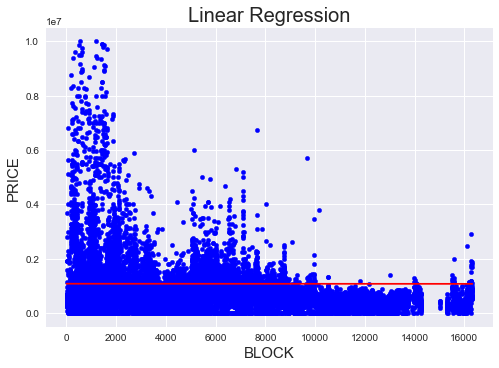

In [77]:
df4 = pd.DataFrame() #NOIA FAZER 
df4['BLOCK'] = dados2.BLOCK
df4['PRICE'] = dados2.SALE_PRICE
npMatrix = np.matrix(df4)
X, Y = npMatrix[:,0], npMatrix[:,1]
# mdl = LinearRegression().fit(X,Y) # either this or the next line
mdl = linear_model.LinearRegression().fit(df4[['BLOCK']],df4.PRICE)
m = mdl.coef_[0]
b = mdl.intercept_
print("formula: y = {0}x + {1}".format(m, b))
df4.plot.scatter(x='BLOCK',y='PRICE',color='blue')
plt.plot([0,max(df4.BLOCK)],[b,m*100+b],'r')
plt.title('Linear Regression', fontsize = 20)
plt.xlabel('BLOCK', fontsize = 15)
plt.ylabel('PRICE', fontsize = 15)
plt.show()

plt.show()

In [55]:
X = df4['PRICE']
Y = df4["BLOCK"]
#X = sm.add_constant(X)
model = sm.OLS(X,Y)
results1 = model.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 1.726e+04
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:21:40   Log-Likelihood:            -3.9299e+05
No. Observations:               26557   AIC:                         7.860e+05
Df Residuals:                   26556   BIC:                         7.860e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BLOCK         75.2847      0.573    131.371      0.000      74.162      76.408
==============================================================================
Omnibus:                     4338.682   Durbin-Watson:                   0.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9039.376
Skew:                           0.981   Prob(JB):                         0.00
Kurtosis:                       5.078   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

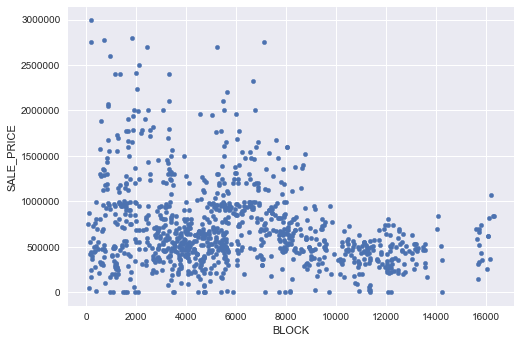

In [56]:
X=[]
Y=[]
import random
my_randoms = random.sample(range(len(dados2)),k=1000)
for i in my_randoms:
    h=dados2.loc[i,"SALE_PRICE"]
    c=dados2.loc[i,"BLOCK"]
    X.append(h)
    Y.append(c)
data1000=pd.DataFrame()
data1000["SALE_PRICE"]=X
data1000["BLOCK"]=Y
data1000.plot.scatter(x="BLOCK",y="SALE_PRICE")
# X=list(h)
# X=pd.Series(X)
# X.hist(normed=True)

In [57]:
X = data1000['SALE_PRICE']
Y = data1000["BLOCK"]
#X = sm.add_constant(X)
model = sm.OLS(X,Y)
results1000 = model.fit()
results1000.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE_PRICE   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     642.7
Date:                Sun, 19 Nov 2017   Prob (F-statistic):          6.96e-110
Time:                        15:21:42   Log-Likelihood:                -14825.
No. Observations:                1000   AIC:                         2.965e+04
Df Residuals:                     999   BIC:                         2.966e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BLOCK         76.5371      3.019     25.352      0.000      70.613      82.461
==============================================================================
Omnibus:                      138.653   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.703
Skew:                           0.890   Prob(JB):                     6.57e-52
Kurtosis:                       4.578   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

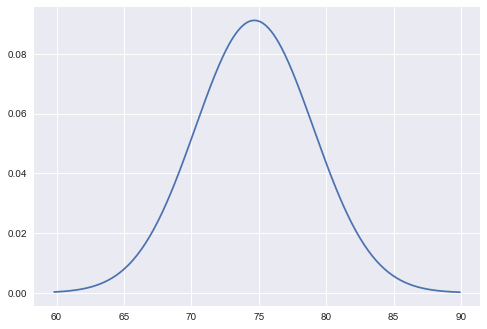

In [58]:
loc=74.67
scale=4.374
N=norm.rvs(loc,scale,1000)
n=np.arange(N.min(),N.max(),0.1)
plt.plot(n,norm.pdf(n,loc,scale))
plt.show()

In [59]:
df = pd.DataFrame()
@interact(rodar_em_x = (0, 360, 20),rodar_em_y = (0, 360, 20))
def f(rodar_em_x=40,rodar_em_y=60):
    df['X'] = dados2.GROSS_SQUARE_FEET
    df['Y'] = dados2.BLOCK
    df['Z'] = dados2.SALE_PRICE
    threedee = plt.figure().gca(projection='3d')
    threedee.scatter(df.X, df.Y, df.Z)
    threedee.set_xlabel('GROSS_SQUARE_FEET')
    threedee.set_ylabel('BLOCK')
    threedee.set_zlabel('PRICE')
    threedee.view_init(rodar_em_x,rodar_em_y )
    plt.show()


In [60]:
df2 = pd.DataFrame()
@interact(rodar_em_x = (0, 360, 20),rodar_em_y = (0, 360, 20))
def f(rodar_em_x=40,rodar_em_y=60):
    df2['X'] = dados2.LAND_SQUARE
    df2['Y'] = dados2.BLOCK
    df2['Z'] = dados2.SALE_PRICE
    threedee = plt.figure().gca(projection='3d')
    threedee.scatter(df2.X, df2.Y, df2.Z)
    threedee.set_xlabel('LAND_SQUARE_FEET')
    threedee.set_ylabel('BLOCK')
    threedee.set_zlabel('PRICE')
    threedee.view_init(rodar_em_x,rodar_em_y )
    plt.show()


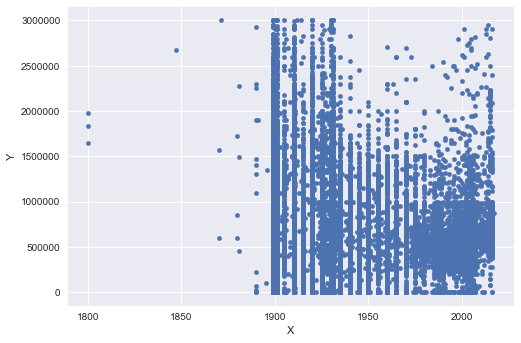

In [61]:
df3 = pd.DataFrame()
df3['X'] = dados2.YEAR_BUILT
df3['Y'] = dados2.SALE_PRICE
df3.plot.scatter(x='X',y='Y')
# df3.plot.set_xlabel('Year Built')
# df3.plot.set_ylabel('Price')
plt.show()

In [62]:
import numpy as np
import statsmodels.api as sm

X = df['Z']
Y = df[['Y','X']]
#X = sm.add_constant(X)
model = sm.OLS(X,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 3.533e+04
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:21:48   Log-Likelihood:            -3.8241e+05
No. Observations:               26557   AIC:                         7.648e+05
Df Residuals:                   26555   BIC:                         7.648e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y              7.6789      0.538     14.279      0.000       6.625       8.733
X            296.9179      1.650    179.922      0.000     293.683     300.152
==============================================================================
Omnibus:                     3616.257   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20659.749
Skew:                           0.527   Prob(JB):                         0.00
Kurtosis:                       7.191   Cond. No.                         4.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
X = df2['Z']
Y = df2[['Y','X']]
#X = sm.add_constant(X)
model = sm.OLS(X,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                 1.699e+04
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:21:49   Log-Likelihood:            -3.8870e+05
No. Observations:               26557   AIC:                         7.774e+05
Df Residuals:                   26555   BIC:                         7.774e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y             17.3969      0.754     23.081      0.000      15.920      18.874
X            154.1986      1.531    100.702      0.000     151.197     157.200
==============================================================================
Omnibus:                     5968.486   Durbin-Watson:                   0.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19598.605
Skew:                           1.134   Prob(JB):                         0.00
Kurtosis:                       6.545   Cond. No.                         3.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# # N = 5 #ESQUECER ESSA PARTE (SO TESTES)
# # arr = np.arange(N*2).reshape(N,2)
# # words=np.array(primeirosBairros)
# df = pd.DataFrame()
# df['X'] = dados2.LAND_SQUARE_FEET
# df['Y'] = dados2.BLOCK
# df['Z'] = dados2.SALE_PRICE
# Xuniques, X = np.unique(df['X'], return_inverse=True)
# Yuniques, Y = np.unique(df['Y'], return_inverse=True)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(X, Y, Z, s=20, c='b')
# ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
#        yticks=range(len(Yuniques)), yticklabels=Yuniques) 
# plt.show()

In [65]:
# headers = pp #serve para analizar cada bairro individualmente depende do n
# headers.head()


In [14]:
# headers.head(5)

In [15]:
# headers.plot.scatter(x="SALE_PRICE",y="BLOCK")

In [16]:
# #E ISSO

# #Ta dando problema com o sale price......

# headers.plot.scatter(x="BLOCK",y="SALE_PRICE")